In [319]:
import numpy as np
import pandas as pd

from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

## Fitness prediction

In [320]:
# control
perf_df = pd.read_csv('/Users/u5802006/Documents/GitHub_repos/nk-2025/results/positional_extrapolation/NK_CONTROL_Performance.csv')

# pos extrap models
perf_pos_df = pd.read_csv('/Users/u5802006/Documents/GitHub_repos/nk-2025/results/positional_extrapolation/NK_Performance.csv')

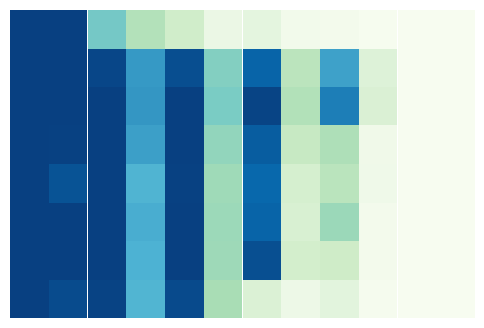

In [306]:
perf_df["Control"] = ["Control"] * len(perf_df)
perf_pos_df["Control"] = ["Extrap"] * len(perf_pos_df)

performance_df = pd.concat([perf_df, perf_pos_df])

# make heatmap of performance
models = performance_df['model'].unique()
n_models = len(models)

models = ['linear', 'rf', 'gb', 'mlp', 'cnn', 'ulstm', 'blstm','transformer']

fig, axs = plt.subplots(8, 6, figsize=(6, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)

for j, k in enumerate(performance_df['landscape'].unique()):
    for i, model in enumerate(models):
        df = performance_df[(performance_df['model'] == model) & (performance_df['landscape'] == k)]
        df = df[df["data_split"] != "train"]
        arr = np.array([[df[df["Control"] == "Control"].pearson_r.mean(),
                       df[df["Control"] == "Extrap"].pearson_r.mean()]])
        sns.heatmap(arr, 
                    ax=axs[i, j], 
                    cmap='GnBu', 
                    cbar=False,
                    vmin=0, vmax=1,
                    square=True)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.savefig("../figures/Fig4/heatmap_performance_incomplete.svg", bbox_inches='tight')

## Mutational effect prediction

In [ ]:
# control
control_df = pd.read_csv('/Users/u5802006/Documents/GitHub_repos/nk-2025/results/positional_extrapolation/NK_CONTROL_MutationalEffectPrediction.csv')
# pos extrap
pos_df = pd.read_csv('/Users/u5802006/Documents/GitHub_repos/nk-2025/results/positional_extrapolation/NK_MutationalEffectPrediction.csv')

In [317]:
control_df[control_df["model"] == "gb"]

,model,landscape,replicate,fixed_site,test_aa,pearson_r,r2,mae
720,gb,k0,r0,0,E,0.024628,-3.485426e+05,0.000011
721,gb,k0,r0,0,D,-0.009987,-7.212269e+07,0.000186
722,gb,k0,r0,0,G,0.025744,-8.877245e+07,0.000199
723,gb,k0,r0,0,C,0.013279,-7.658444e+07,0.000187
724,gb,k0,r0,0,F,-0.010468,-1.819490e+05,0.000005
...,...,...,...,...,...,...,...,...
1435,gb,k5,r4,5,E,NaN,-5.569706e-04,0.163839
1436,gb,k5,r4,5,D,NaN,-3.046488e-03,0.161922
1437,gb,k5,r4,5,G,NaN,-4.219182e-04,0.164154
1438,gb,k5,r4,5,C,NaN,-4.721497e-03,0.160993


In [321]:
models = pos_df['model'].unique()
landscapes = pos_df['landscape'].unique()

ks_stats = {"model": [], "landscape": [], "ks_stat": [], "p_value": []}

for i, model in enumerate(models):

    model_data = pos_df.loc[pos_df['model'] == model, 'mae'].dropna()
    control_model_data = control_df.loc[control_df['model'] == model, 'mae'].dropna()
    
    bins = np.linspace(0, 0.45, 21)
    
    for j, landscape in enumerate(landscapes):
        
        landscape_df = pos_df[
            (pos_df['model'] == model) & 
            (pos_df['landscape'] == landscape)
        ]
        control_landscape_df = control_df[
            (control_df['model'] == model) & 
            (control_df['landscape'] == landscape)
        ]

        extrap_maes = landscape_df['mae'].to_numpy()
        control_maes = control_landscape_df['mae'].to_numpy()
        
        ks_stat, p_value = ks_2samp(control_maes, extrap_maes)

        ks_stats["model"].append(model)
        ks_stats["landscape"].append(landscape)
        ks_stats["ks_stat"].append(ks_stat)
        ks_stats["p_value"].append(p_value)

In [324]:
pd.DataFrame(ks_stats).to_csv("../results/positional_extrapolation/ks_stats.csv", index=False)

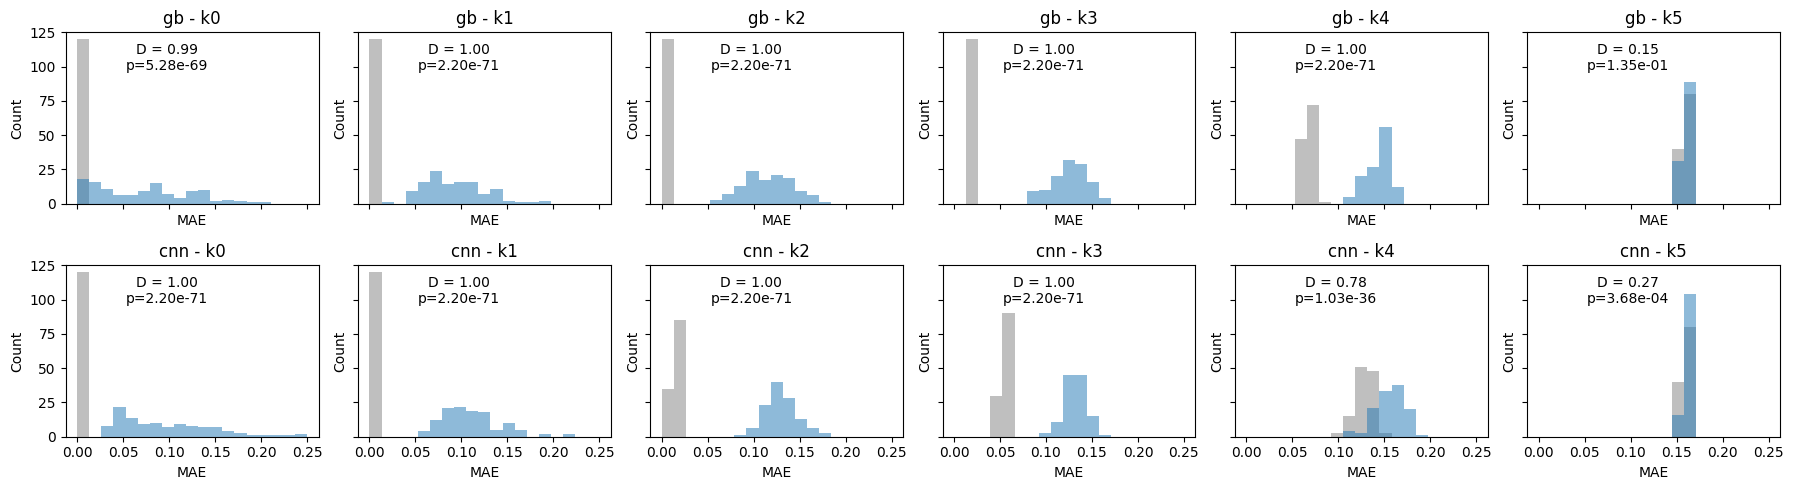

In [ ]:
models = ["gb", "cnn"]
landscapes = [f"k{i}" for i in range(6)]

fig, axes = plt.subplots(
    nrows=len(models),
    ncols=len(landscapes),
    figsize=(3 * len(landscapes), 2.5 * len(models)),
    sharex=True,
    sharey=True,
)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, model in enumerate(models):

    model_data = pos_df.loc[pos_df['model'] == model, 'mae'].dropna()
    control_model_data = control_df.loc[control_df['model'] == model, 'mae'].dropna()
    
    bins = np.linspace(0, 0.25, 20)
    
    for j, landscape in enumerate(landscapes):
        ax = axes[i, j] 
        
        # Subset data for this landscape
        landscape_df = pos_df[
            (pos_df['model'] == model) & 
            (pos_df['landscape'] == landscape)
        ]
        control_landscape_df = control_df[
            (control_df['model'] == model) & 
            (control_df['landscape'] == landscape)
        ]

        extrap_maes = landscape_df['mae'].to_numpy()
        control_maes = control_landscape_df['mae'].to_numpy()
        ks_stat, p_value = ks_2samp(control_maes, extrap_maes)
        
        ax.text(0.4, 0.85, f"D = {ks_stat:.2f}\np={p_value:.2e}", ha='center', va='center', transform=ax.transAxes)

        # Plot histograms on the same Axes, using the same bins
        ax.hist(
            control_landscape_df['mae'].dropna(),
            bins=bins,
            alpha=0.5,
            color='gray',
            label='Control'
        )
        ax.hist(
            landscape_df['mae'].dropna(),
            bins=bins,
            alpha=0.5,
            label='Model'
        )
        
        # Labeling
        ax.set_ylim(0, 125)
        ax.set_title(f"{model} - {landscape}")
        ax.set_xlabel("MAE")
        ax.set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("../figures/Fig4/effect_prediction_mae_hists_CNN_GBT.svg", bbox_inches='tight')
plt.show()


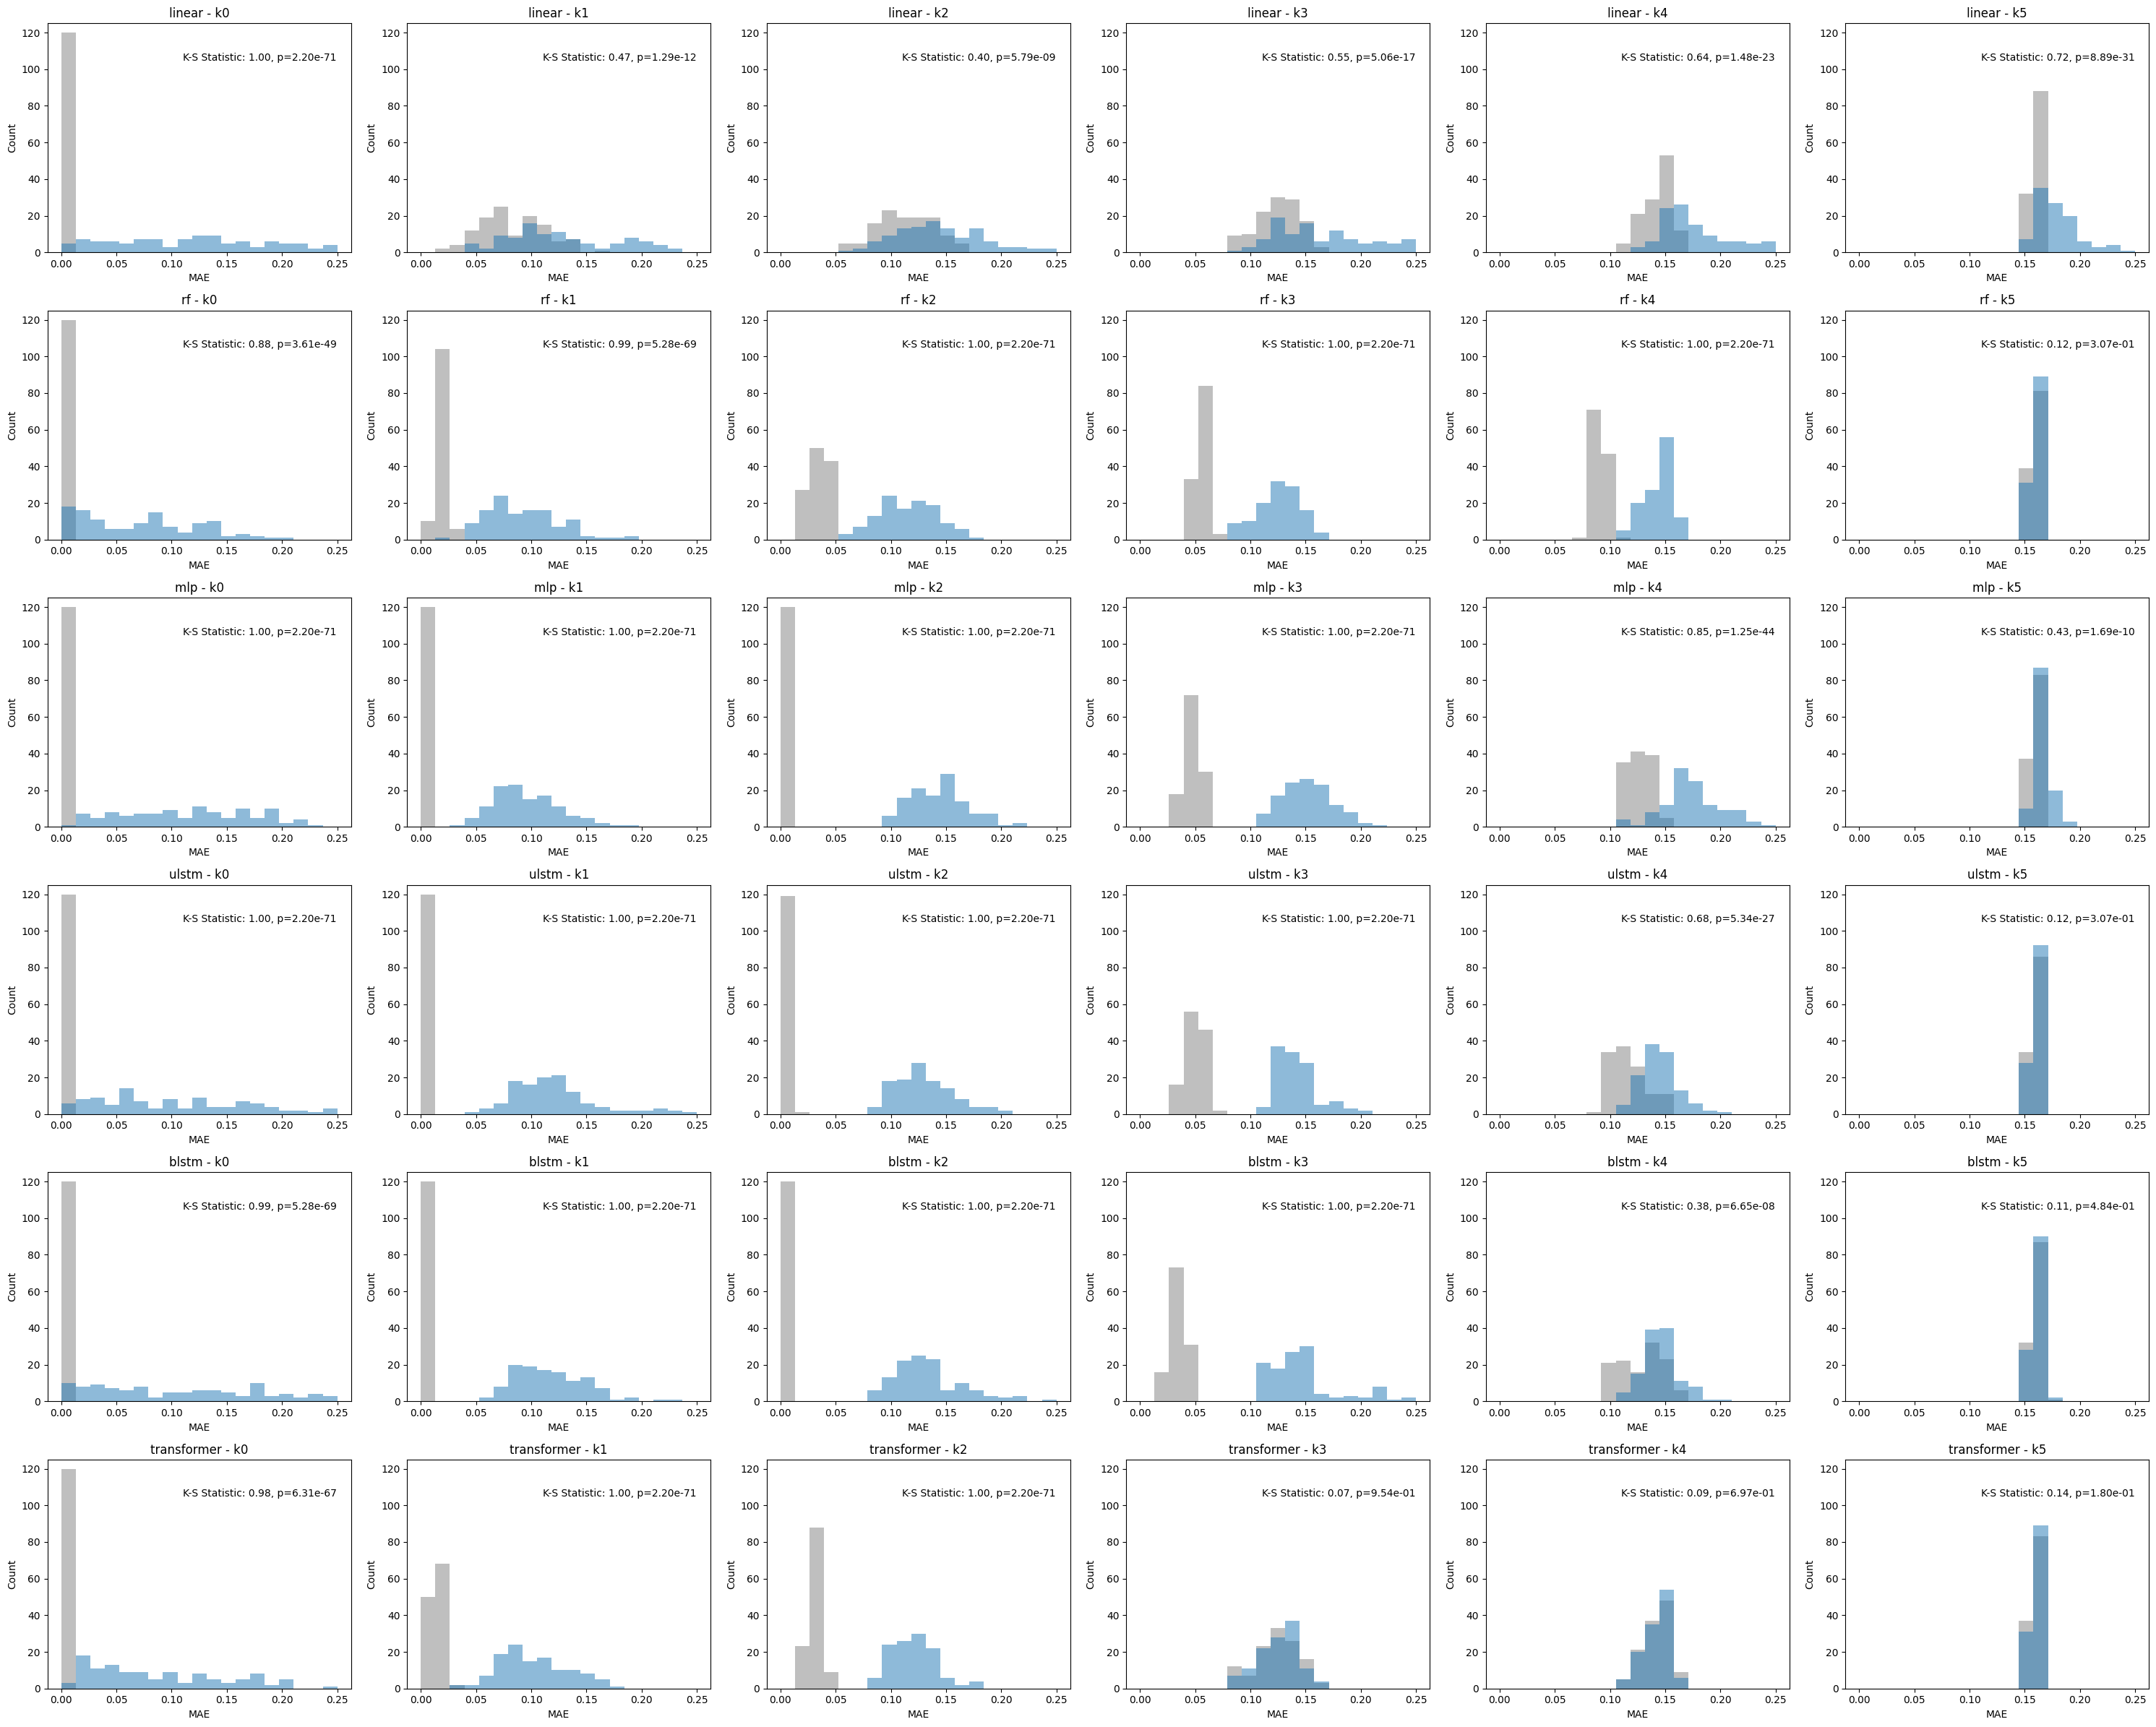

In [346]:
models = ['linear', 'rf', 'mlp', 'ulstm', 'blstm','transformer']
landscapes = [f"k{i}" for i in range(6)]

fig, axes = plt.subplots(
    nrows=len(models),
    ncols=len(landscapes),
    figsize=(5 * len(landscapes), 4 * len(models)),
)

for i, model in enumerate(models):

    model_data = pos_df.loc[pos_df['model'] == model, 'mae'].dropna()
    control_model_data = control_df.loc[control_df['model'] == model, 'mae'].dropna()
    
    bins = np.linspace(0, 0.25, 20)
    
    for j, landscape in enumerate(landscapes):
        ax = axes[i, j] 
        
        # Subset data for this landscape
        landscape_df = pos_df[
            (pos_df['model'] == model) & 
            (pos_df['landscape'] == landscape)
        ]
        control_landscape_df = control_df[
            (control_df['model'] == model) & 
            (control_df['landscape'] == landscape)
        ]

        extrap_maes = landscape_df['mae'].to_numpy()
        control_maes = control_landscape_df['mae'].to_numpy()
        ks_stat, p_value = ks_2samp(control_maes, extrap_maes)
        
        ax.text(0.7, 0.85, f"K-S Statistic: {ks_stat:.2f}, p={p_value:.2e}", ha='center', va='center', transform=ax.transAxes)

        # Plot histograms on the same Axes, using the same bins
        ax.hist(
            control_landscape_df['mae'].dropna(),
            bins=bins,
            alpha=0.5,
            color='gray',
            label='Control'
        )
        ax.hist(
            landscape_df['mae'].dropna(),
            bins=bins,
            alpha=0.5,
            label='Model'
        )
        
        # Labeling
        ax.set_ylim(0, 125)
        ax.set_title(f"{model} - {landscape}")
        ax.set_xlabel("MAE")
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


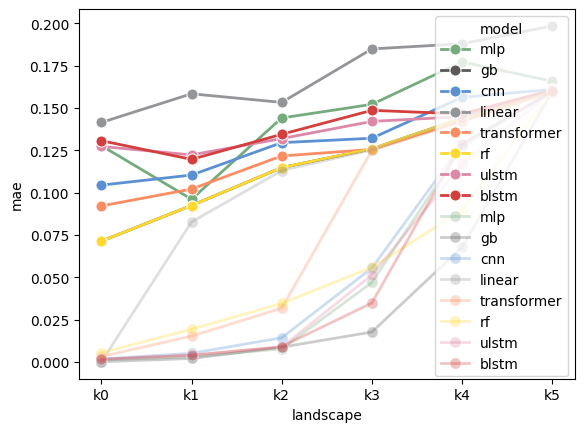

In [389]:
from matplotlib import markers
import matplotlib.colors as mcolors
from pyparsing import line


colors = [
    "#76AB7E",  # Green
    "#5A5958",  # dark grey 
    "#5B91D2",  # Blue
    "#939598",  # grey
    "#FC8D62",  # orange
    "#FFD92F",  # Yellow
    "#DC88A8",  # Pink
    "#D23F3E"   # Red
]

custom_cmap = mcolors.ListedColormap(colors, name='custom_cmap')

sns.lineplot(data=pos_df, x='landscape', y='mae', 
             hue='model', palette=list(custom_cmap.colors),
             errorbar=None, marker='o', linewidth=2, markersize=8,
             )

sns.lineplot(data=control_df, x='landscape', y='mae', 
             hue='model', palette=list(custom_cmap.colors),
             errorbar=None, marker='o', linewidth=2, markersize=8, alpha=0.3,
             )

plt.savefig("../figures/Fig4/effect_prediction_mae_lineplot.svg", bbox_inches='tight')
plt.show()

In [246]:
# control
control_df = pd.read_csv('/Users/u5802006/Documents/GitHub_repos/nk-2025/results/positional_extrapolation/GB1_CONTROL_MutationalEffectPrediction.csv')

# pos extrap
pos_extrap_df = pd.read_csv('/Users/u5802006/Documents/GitHub_repos/nk-2025/results/positional_extrapolation/GB1_MutationalEffectPrediction.csv')

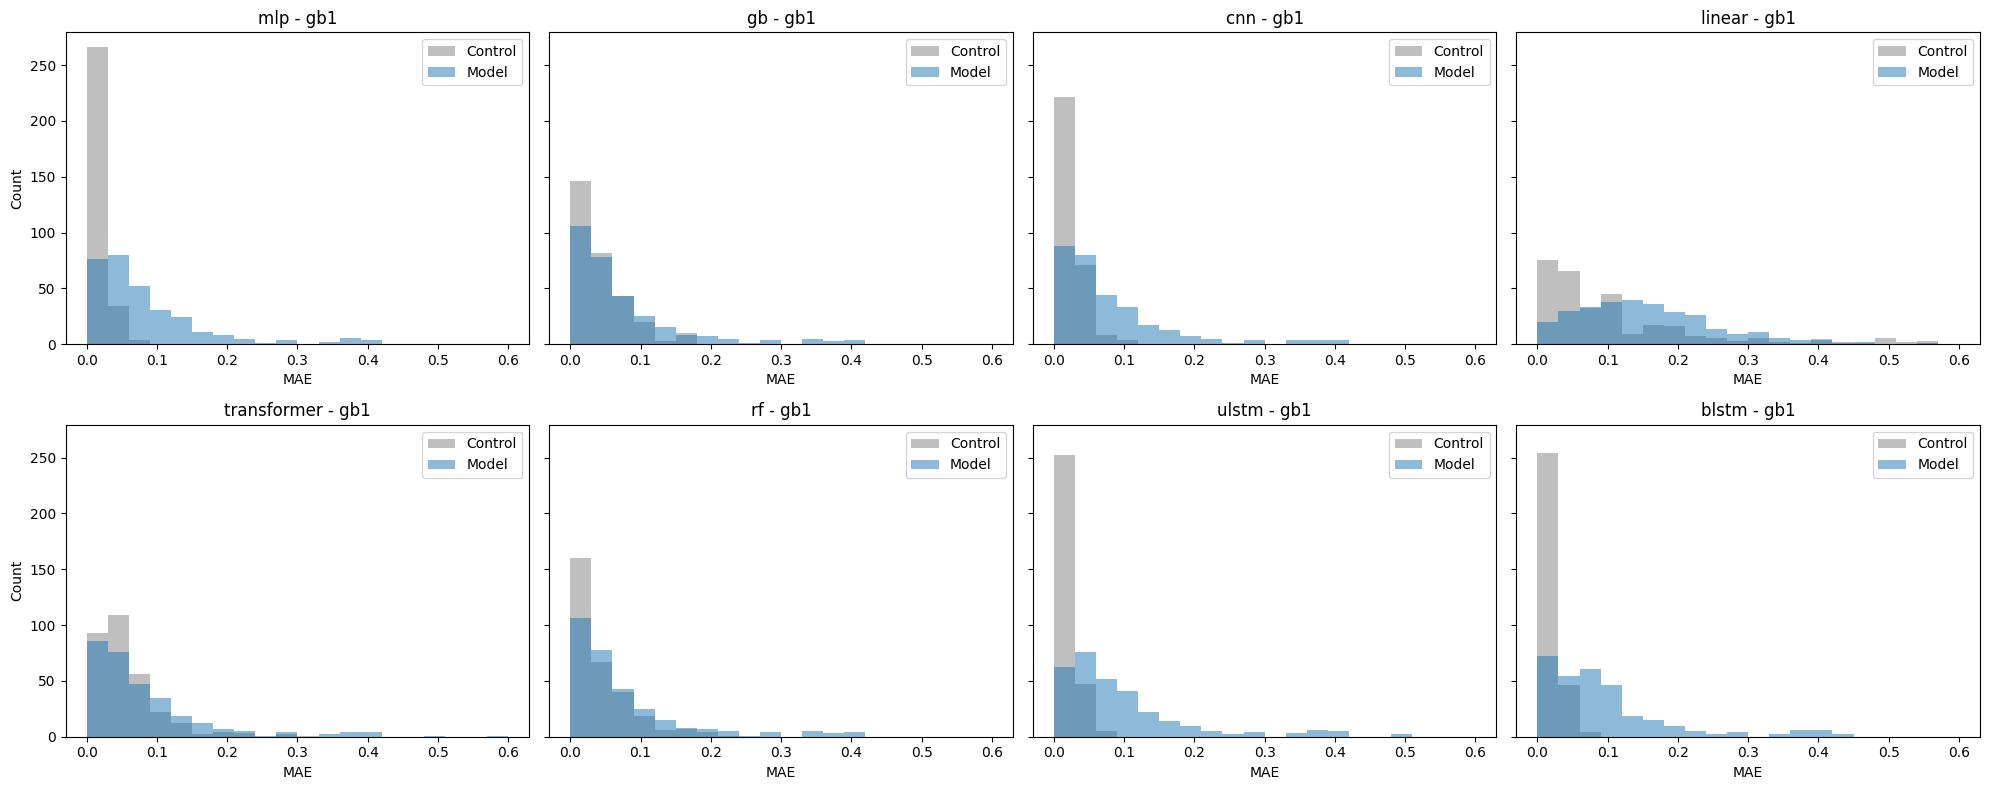

In [247]:
import numpy as np
import matplotlib.pyplot as plt

# Specify the fixed landscape (adjust as needed)
landscape = 'gb1'  # Replace with your specific landscape value

# Get unique models
models = pos_extrap_df['model'].unique()
n_models = len(models)

# Set up a subplot grid with 2 rows and 4 columns (for 8 models)
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
axes = axes.flatten()  # Flatten the grid to easily index each subplot

for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Subset the data for this model and the chosen landscape
    model_data = pos_extrap_df[
        (pos_extrap_df['model'] == model) & 
        (pos_extrap_df['landscape'] == landscape)
    ]['mae'].dropna()
    
    control_data = control_df[
        (control_df['model'] == model) & 
        (control_df['landscape'] == landscape)
    ]['mae'].dropna()
    
    # Combine the two datasets to compute common bin edges for the model
    combined_data = np.concatenate([model_data.values, control_data.values])
    bins = np.linspace(0, 0.6, 21)  # 20 bins
    
    # Plot histograms on the same axes
    ax.hist(control_data, bins=bins, alpha=0.5, color='gray', label='Control')
    ax.hist(model_data, bins=bins, alpha=0.5, label='Model')
    
    ax.set_title(f"{model} - {landscape}")
    ax.set_xlabel("MAE")
    if idx % n_cols == 0:  # Label y-axis for the first column in each row
        ax.set_ylabel("Count")
    ax.legend()

# Hide any unused subplots if n_models is less than n_rows*n_cols
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


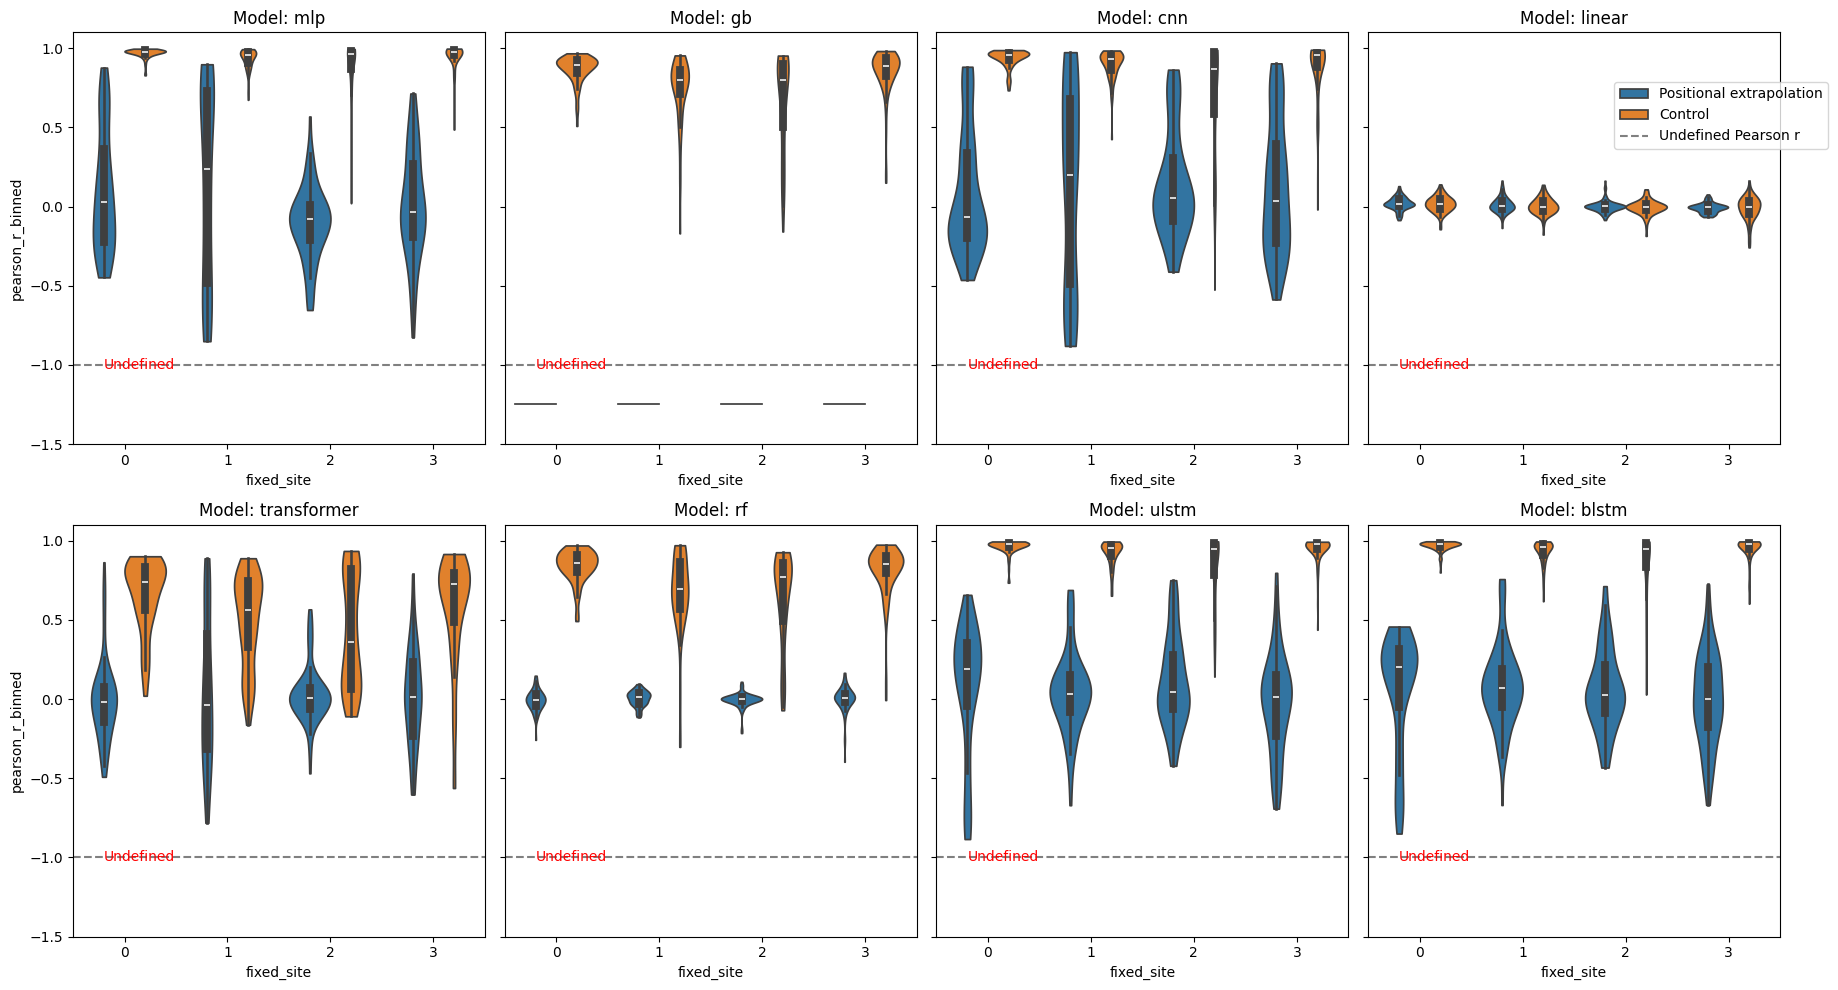

In [248]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the unique models
models = pos_extrap_df['model'].unique()
n_models = len(models)

# Create a figure with 2 rows and 4 columns of subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
axs = axs.flatten()  # Flatten to easily iterate over

# Iterate over each model
for idx, model in enumerate(models):
    ax = axs[idx]
    
    # Filter data for the current model and work on copies
    df_model = pos_extrap_df[pos_extrap_df['model'] == model].copy()
    control_df_model = control_df[control_df['model'] == model].copy()

    # Add a control label to each dataframe
    df_model["control"] = "Positional extrapolation"
    control_df_model["control"] = "Control"

    # Combine experimental and control data
    full_df = pd.concat([df_model, control_df_model])

    # Determine the minimum defined Pearson r value
    defined_vals = full_df['pearson_r'].dropna()
    if len(defined_vals) > 0:
        min_defined = defined_vals.min()
    else:
        min_defined = 0  # Fallback if all values are undefined

    # Define a bin value for undefined entries: slightly lower than the minimum defined value.
    bin_value = -1.25

    # Create a new column for plotting: replace NaN (undefined) values with the bin_value.
    full_df['pearson_r_binned'] = full_df['pearson_r']
    full_df.loc[full_df['pearson_r'].isna(), 'pearson_r_binned'] = bin_value

    # Create the violin plot using the binned column and set cut=0 to prevent density extension
    sns.violinplot(
        data=full_df,
        x='fixed_site',
        y='pearson_r_binned',
        hue='control',
        cut=0,
        ax=ax
    )

    # Add a horizontal dashed line at the bin_value to indicate the undefined category.
    ax.axhline(-1, color='grey', linestyle='--', label='Undefined Pearson r')

    ax.text(
        x=-0.2,               
        y=-1, 
        s='Undefined', 
        color='red', 
        verticalalignment='center'
    )

    # Set y-axis limits so that the top is 1 (or a value of your choosing) and bottom includes the bin.
    ax.set_ylim(-1.5, 1.1)
    
    ax.set_title(f"Model: {model}")
    
    # Remove individual legends to avoid redundancy later
    ax.get_legend().remove()

# Create one global legend outside the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.92, 0.92))
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the unique models
models = pos_extrap_df['model'].unique()
n_models = len(models)

# Create a figure with 2 rows and 4 columns of subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
axs = axs.flatten()  # Flatten to easily iterate over

# Iterate over each model
for idx, model in enumerate(models):
    ax = axs[idx]
    
    # Filter data for the current model and work on copies
    df_model = pos_extrap_df[pos_extrap_df['model'] == model].copy()
    control_df_model = control_df[control_df['model'] == model].copy()

    # Add a control label to each dataframe
    df_model["control"] = "Positional extrapolation"
    control_df_model["control"] = "Control"

    

    # Set y-axis limits so that the top is 1 (or a value of your choosing) and bottom includes the bin.
    ax.set_ylim(-1.5, 1.1)
    
    ax.set_title(f"Model: {model}")
    
    # Remove individual legends to avoid redundancy later
    ax.get_legend().remove()

# Create one global legend outside the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.92, 0.92))
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
